# Extract features from a penultimate layer in Emotion English DistilRoBERTa-base model

In [1]:
# install the transformers library
!pip install transformers

# import required packages
import csv
import numpy as np
import pandas as pd
import pickle as pk
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import plotly.express as px

# work with cuda
device = torch.device('cuda')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 6.5 MB/s 
     |████████████████████████████████| 182 kB 67.9 MB/s 
     |████████████████████████████████| 7.6 MB 47.0 MB/s 


In [41]:
import plotly.express as px

In [2]:
# load tokenizer and model
model_name = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.to(device)

Downloading:   0%|          | 0.00/294 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

## Preparation of dataset

### **Option 1** list of texts



In [ ]:
# create list of texts
pred_texts = ['I like that', 'That is annoying', 'This is great!', 'Wouldn´t recommend it.']

### **Option 2** texts from csv file

In [3]:
# run cell and select file for upload
from google.colab import files
files.upload()

print("end")

Saving tweets.csv to tweets.csv
end


In [4]:
# specify your filename

# note: you can right-click on your file and copy-paste the path to it here
file_name = "/content/tweets.csv" 

 # select the column in your csv that contains the text to be classified
text_column = "text"
hashtag_column = "hashtag"
user_column = "username"

# read in csv
reader = csv.DictReader(open(file_name, "r"), delimiter='\\')
df_pred = pd.DataFrame.from_dict(reader)
# pred_texts = df_pred[text_column].dropna().astype('str').tolist()
hashtags_col = df_pred[hashtag_column]
hashtags = df_pred[hashtag_column].unique()
pred_texts = df_pred[text_column]
usernames = df_pred[user_column]

## Functions for extracting

In [5]:
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

In [6]:
model.classifier.dense.register_forward_hook(get_features('feats'))

## Extract features from penultimate layer

In [7]:
# placeholders
PREDICTIONS = []
FEATS = []

# placeholder for batch features
features = {}

for idx, inputs in enumerate(pred_texts):
     
    inputs = tokenizer(inputs, return_tensors="pt")
    inputs = inputs.to(device)

    predictions=model(**inputs).logits

    PREDICTIONS.append(predictions.detach().cpu().numpy())
    FEATS.append(features['feats'].cpu().numpy())
       

In [8]:
# Inspect features

PREDICTIONS = np.concatenate(PREDICTIONS)
FEATS = np.concatenate(FEATS)

print('preds shape:', PREDICTIONS.shape)
print('feats shape:', FEATS.shape)

preds shape: (17318, 7)
feats shape: (17318, 768)


#Preprocessing features for PCA

In [21]:
# standarizedFeatures = StandardScaler().fit_transform(FEATS[:,:])

# pd.DataFrame(data = standarizedFeatures).head()

#Testing minimum number of principal components to reach 95% of the variance
####Calculating PCA

In [55]:
normal_transform = Normalizer(norm='l2').fit(FEATS)

normalizedFeatures = normal_transform.transform(FEATS)

pd.DataFrame(data = normalizedFeatures).head()

0         1         2         3         4         5         6    \
0 -0.009527  0.080709 -0.003900  0.063360 -0.053345 -0.002078  0.003341   
1  0.043048  0.077316  0.011393  0.049942 -0.043316  0.002207 -0.039942   
2 -0.018795  0.064016 -0.022025  0.055901 -0.067684  0.001872  0.028228   
3  0.002403  0.071408 -0.014525  0.056563 -0.054614  0.008381  0.004633   
4 -0.014116  0.081163 -0.007160  0.062333 -0.049573  0.007270  0.001691   

        7         8         9    ...       758       759       760       761  \
0  0.009126 -0.002801 -0.010006  ... -0.012548 -0.000920  0.012760  0.026442   
1  0.003293 -0.000245  0.003148  ...  0.004560 -0.024379  0.023197  0.012777   
2  0.018212  0.014965 -0.017819  ... -0.019891  0.005758 -0.003129  0.013456   
3  0.019828 -0.001609 -0.005007  ... -0.011930 -0.015980  0.000373  0.012266   
4  0.011587 -0.000732  0.001246  ... -0.006463 -0.002589  0.014291  0.024287   

        762       763       764       765       766       767  
0  0.025127  0.026482 -0.082747 -0.059574  0.042251  0.011221  
1  0.000445  0.020171 -0.074125 -0.056072  0.051640  0.016752  
2  0.041844  0.034887 -0.089033 -0.064825  0.051113 -0.003876  
3  0.024380  0.026088 -0.087962 -0.067552  0.041013  0.002805  
4  0.022027  0.018696 -0.083215 -0.062249  0.041343  0.015171  

[5 rows x 768 columns]

In [13]:
# Make an instance of the Model
pca = PCA(n_components=2)

pca.fit(normalizedFeatures)

principalComponents = pca.transform(normalizedFeatures)

with open('pca.pkl', 'wb') as pickle_file:
        pk.dump(pca, pickle_file)

files.download('pca.pkl')

pd.DataFrame(data = principalComponents).head()

0         1
0 -0.501812  0.035100
1 -0.189808  0.015253
2 -0.601376 -0.147836
3 -0.449840 -0.126341
4 -0.503203  0.111204

In [15]:
pca2 = PCA(n_components=3)

pca2.fit(normalizedFeatures)

principalComponents2 = pca2.transform(normalizedFeatures)

with open('pca2.pkl', 'wb') as pickle_file:
        pk.dump(pca2, pickle_file)

files.download('pca2.pkl')

pd.DataFrame(data = principalComponents2).head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0         1         2
0 -0.501812  0.035100  0.018220
1 -0.189808  0.015253  0.313727
2 -0.601376 -0.147836 -0.032973
3 -0.449840 -0.126341  0.060691
4 -0.503203  0.111204  0.017486

#Normalizing each principal component

In [ ]:
# Scale data between -1 and 1
principalComponents = pd.DataFrame(data = principalComponents)
# scaler = MinMaxScaler(feature_range=(-1, 1))
# principalComponents = pd.DataFrame(data = scaler.fit_transform(principalComponents))
principalComponents = pd.DataFrame(data = principalComponents)

principalComponents.head()

0         1
0 -0.492643 -0.360239
1 -0.219164 -0.167780
2 -0.816361 -0.446115
3 -0.290127  0.282821
4 -0.150670 -0.072155

In [16]:
principalComponents = pd.DataFrame(data = principalComponents)
principalComponents2 = pd.DataFrame(data = principalComponents2)

In [ ]:
# def min_max_scaling(series):
#     return (series - series.min()) / (series.max() - series.min())

In [17]:
# for i in range(principalComponents.shape[1]):
#     principalComponents[:,i] = min_max_scaling(principalComponents[:,i])


pred_texts = pd.concat([pred_texts, hashtags_col, usernames], axis=1)
finalData = pd.concat([pred_texts, principalComponents], axis=1)
finalData.head()

text hashtag       username  \
0  matt gilhooly discovered where to find #fulfil...    #joy   bernieborges   
1  always stay #humble & #kind #joytrain #joy #lo...    #joy       KariJoys   
2  so much fun today at the uucville holiday part...    #joy       uucville   
3  gaudete! what better way to celebrate gaudete ...    #joy   tyroleanlass   
4  we are all influencers. be a good one. into th...    #joy  SHendersonArt   

          0         1  
0 -0.501812  0.035100  
1 -0.189808  0.015253  
2 -0.601376 -0.147836  
3 -0.449840 -0.126341  
4 -0.503203  0.111204

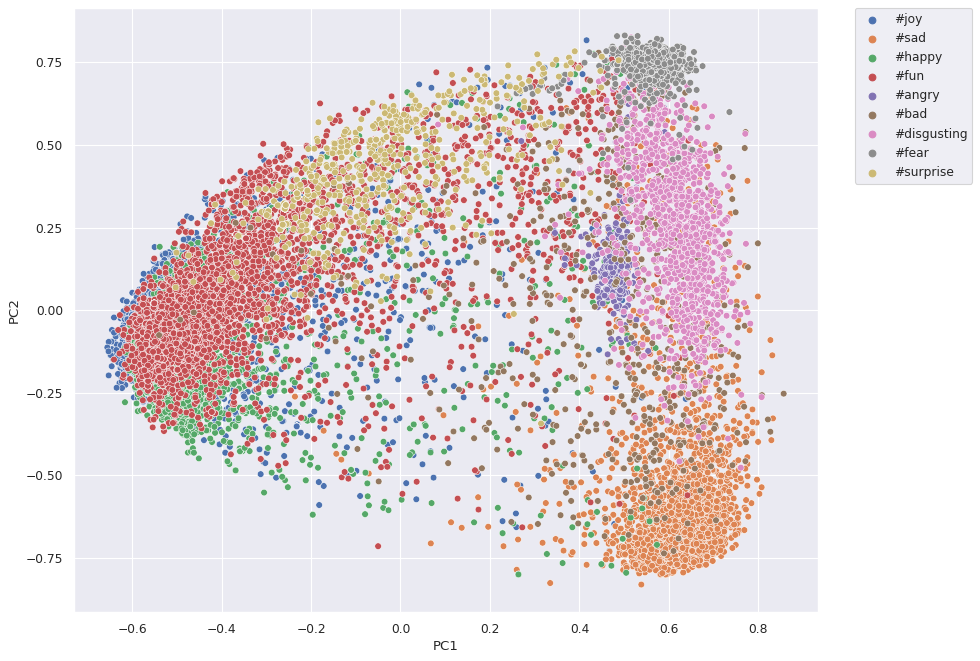

In [31]:
sns.set(style = "darkgrid")
fig = plt.figure(figsize=(12, 10), dpi=80)

g = sns.scatterplot(x=0, y=1,
                  hue="hashtag",
                  data=finalData,
                  legend=True)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.show()

In [18]:
# for i in range(principalComponents2.shape[1]):
#     principalComponents2[:,i] = min_max_scaling(principalComponents2[:,i])

finalData2 = pd.concat([pred_texts, principalComponents2], axis=1)
finalData2.head()

text hashtag       username  \
0  matt gilhooly discovered where to find #fulfil...    #joy   bernieborges   
1  always stay #humble & #kind #joytrain #joy #lo...    #joy       KariJoys   
2  so much fun today at the uucville holiday part...    #joy       uucville   
3  gaudete! what better way to celebrate gaudete ...    #joy   tyroleanlass   
4  we are all influencers. be a good one. into th...    #joy  SHendersonArt   

          0         1         2  
0 -0.501812  0.035100  0.018220  
1 -0.189808  0.015253  0.313727  
2 -0.601376 -0.147836 -0.032973  
3 -0.449840 -0.126341  0.060691  
4 -0.503203  0.111204  0.017486

In [50]:
fig = plt.figure(figsize=(10, 20), dpi=80)

fig = px.scatter_3d(finalData2, x=0, y=1, z=2, color='hashtag')

fig.update_traces(marker_size = 4)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

<Figure size 800x1600 with 0 Axes>

In [56]:
pca_whiten = PCA(n_components=2, whiten=True)

pca_whiten.fit(normalizedFeatures)

principalComponents_v2 = pca_whiten.transform(normalizedFeatures)

with open('pca_whiten.pkl', 'wb') as pickle_file:
        pk.dump(pca_whiten, pickle_file)

files.download('pca_whiten.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
principalComponents_v2 = pd.DataFrame(data = principalComponents_v2)
finalData_v2 = pd.concat([pred_texts, principalComponents_v2], axis=1)

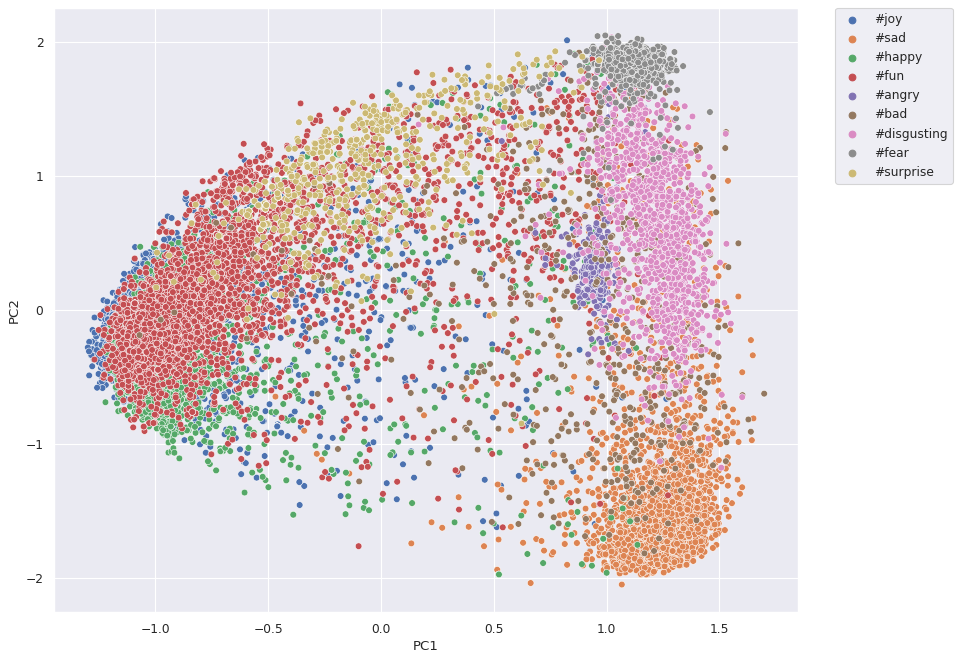

In [58]:
sns.set(style = "darkgrid")
fig = plt.figure(figsize=(12, 10), dpi=80)

g = sns.scatterplot(x=0, y=1,
                  hue="hashtag",
                  data=finalData_v2,
                  legend=True)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.show()

In [59]:
pca_whiten2 = PCA(n_components=3, whiten=True)

pca_whiten2.fit(normalizedFeatures)

principalComponents2_v2 = pca_whiten2.transform(normalizedFeatures)

with open('pca_whiten2.pkl', 'wb') as pickle_file:
        pk.dump(pca_whiten2, pickle_file)

files.download('pca_whiten2.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [60]:
principalComponents2_v2 = pd.DataFrame(data = principalComponents2_v2)
finalData2_v2 = pd.concat([pred_texts, principalComponents2_v2], axis=1)

In [61]:
fig = plt.figure(figsize=(10, 20), dpi=80)

fig = px.scatter_3d(finalData2_v2, x=0, y=1, z=2, color='hashtag')

fig.update_traces(marker_size = 4)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

<Figure size 800x1600 with 0 Axes>

# Normalizing PC after whiten PCA

In [63]:
pca_normal_transform = Normalizer(norm='l2').fit(principalComponents_v2)

principalComponents_v2_norm = pca_normal_transform.transform(principalComponents_v2)

pca_normal_transform = Normalizer(norm='l2').fit(principalComponents2_v2)

principalComponents2_v2_norm = pca_normal_transform.transform(principalComponents2_v2)

In [65]:
principalComponents_v2_norm = pd.DataFrame(data = principalComponents_v2_norm)
finalData_v2_normalized = pd.concat([pred_texts, principalComponents_v2_norm], axis=1)

principalComponents2_v2_norm = pd.DataFrame(data = principalComponents2_v2_norm)
finalData2_v2_normalized = pd.concat([pred_texts, principalComponents2_v2_norm], axis=1)

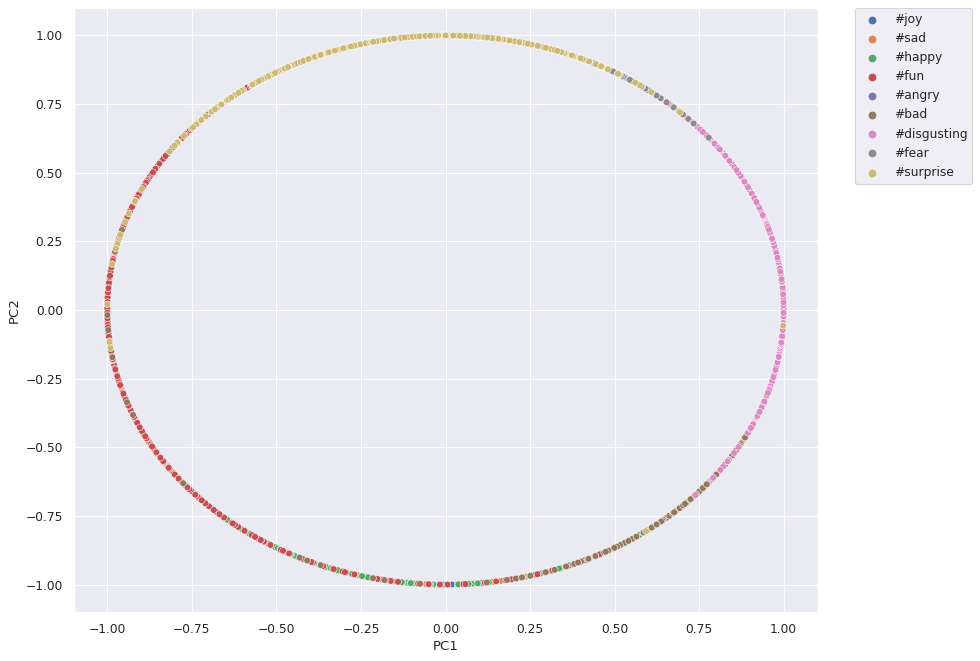

In [66]:
sns.set(style = "darkgrid")
fig = plt.figure(figsize=(12, 10), dpi=80)

g = sns.scatterplot(x=0, y=1,
                  hue="hashtag",
                  data=finalData_v2_normalized,
                  legend=True)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.show()

In [67]:
fig = plt.figure(figsize=(10, 20), dpi=80)

fig = px.scatter_3d(finalData2_v2_normalized, x=0, y=1, z=2, color='hashtag')

fig.update_traces(marker_size = 4)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

<Figure size 800x1600 with 0 Axes>

#Min max scaling PC after whiten PCA

In [68]:
scaler = MinMaxScaler(feature_range=(-1, 1))

principalComponents_v2_minmax = pd.DataFrame(data = scaler.fit_transform(principalComponents_v2))
finalData_v2_minmax = pd.concat([pred_texts, principalComponents_v2_minmax], axis=1)

scaler = MinMaxScaler(feature_range=(-1, 1))

principalComponents2_v2_minmax = pd.DataFrame(data = scaler.fit_transform(principalComponents2_v2))
finalData2_v2_minmax = pd.concat([pred_texts, principalComponents2_v2_minmax], axis=1)

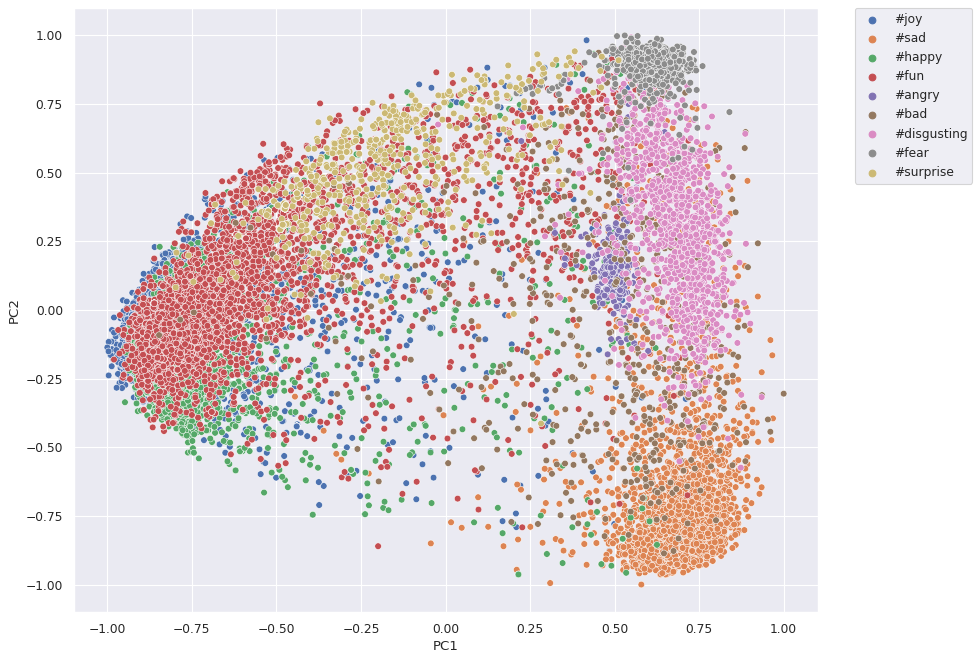

In [69]:
sns.set(style = "darkgrid")
fig = plt.figure(figsize=(12, 10), dpi=80)

g = sns.scatterplot(x=0, y=1,
                  hue="hashtag",
                  data=finalData_v2_minmax,
                  legend=True)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.show()

In [70]:
fig = plt.figure(figsize=(10, 20), dpi=80)

fig = px.scatter_3d(finalData2_v2_minmax, x=0, y=1, z=2, color='hashtag')

fig.update_traces(marker_size = 4)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

<Figure size 800x1600 with 0 Axes>

In [ ]:
# Normalize results

# for i in range(PREDICTIONS.shape[0]):
#     PREDICTIONS[i,:] = min_max_scaling(PREDICTIONS[i,:])
# pd.DataFrame(data = PREDICTIONS).head()

0    1         2         3         4         5         6
0  0.581599  0.0  1.000000  0.495911  0.114639  0.392697  0.242955
1  0.619459  0.0  1.000000  0.653886  0.312912  0.373442  0.267734
2  1.000000  0.0  0.984902  0.212585  0.025690  0.150115  0.116667
3  0.910536  0.0  1.000000  0.731483  0.528817  0.988611  0.712866
4  0.675931  0.0  1.000000  0.719822  0.339041  0.444265  0.426783

#Creating JSON to frontend

In [71]:
import json

In [80]:
import datetime;

ct = datetime.datetime.now()

colors = [
    "#e60049",
    "#0bb4ff",
    "#50e991",
    "#e6d800",
    "#9b19f5",
    "#ffa300",
    "#dc0ab4",
    "#b3d4ff",
    "#00bfa0"
]

def saveAsJSON (componentsNum, dataframe):
  data = {}
  dataArr = []

  for i in range(len(hashtags)):
    ct = datetime.datetime.now()
    hashtagDf = dataframe[dataframe[hashtag_column] == hashtags[i]]
    new_group = {
      "message": "Udało się pobrać post",
      "id": str(ct.timestamp()),
      "title": hashtags[i] + " " + "{}".format(hashtagDf.shape[0]),
      "color": colors[i],
      "twitts": [],
    }
    twittsData = []
    for index, row in hashtagDf.iterrows():
      if componentsNum == 2:
        tweetfeature = {
            'x': row[0],
            'y': row[1],
            'twitt': row['text'],
            'user': row['username']
        }
      elif componentsNum == 3:
        tweetfeature = {
            'x': row[0],
            'y': row[1],
            'z': row[2],
            'twitt': row['text'],
            'user': row['username']
        }
      twittsData.append(tweetfeature)
    new_group['twitts'] = twittsData
    dataArr.append(new_group)
  return dataArr


In [81]:
whitenPCA2D = saveAsJSON(2, finalData_v2_minmax)
whitenPCA3D = saveAsJSON(3, finalData2_v2_minmax)

notWhitenPCA2D = saveAsJSON(2, finalData)
notWhitenPCA3D = saveAsJSON(3, finalData2)

whitenPCA2DNormalized = saveAsJSON(2, finalData_v2_normalized)
whitenPCA3DNormalized = saveAsJSON(3, finalData2_v2_normalized)

In [82]:
with open('whitenPCA2D.json', 'w', encoding='UTF8') as outfile1:
  json.dump(whitenPCA2D, outfile1)

with open('whitenPCA3D.json', 'w', encoding='UTF8') as outfile2:
  json.dump(whitenPCA3D, outfile2)

with open('notWhitenPCA2D.json', 'w', encoding='UTF8') as outfile3:
  json.dump(notWhitenPCA2D, outfile3)

with open('notWhitenPCA3D.json', 'w', encoding='UTF8') as outfile4:
  json.dump(notWhitenPCA3D, outfile4)

with open('whitenPCA2DNormalized.json', 'w', encoding='UTF8') as outfile5:
  json.dump(whitenPCA2DNormalized, outfile5)

with open('whitenPCA3DNormalized.json', 'w', encoding='UTF8') as outfile6:
  json.dump(whitenPCA3DNormalized, outfile6)

In [83]:
files.download('whitenPCA2D.json')
files.download('whitenPCA3D.json')

files.download('notWhitenPCA2D.json')
files.download('notWhitenPCA3D.json')

files.download('whitenPCA2DNormalized.json')
files.download('whitenPCA3DNormalized.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>